<a href="https://colab.research.google.com/github/nlp-en-es/nlp-de-cero-a-cien/blob/main/2_modelos_secuenciales/LSTM_NLP_clasificador_novelas_español.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clasificación de texto usando LSTMs con TensorFlow 2.0

Vamos a crear una Red Neuronal Recurrente (BiLSTM) capaz de clasificar si una secuencia de una novela pertenece a Benito Pérez Galdós o Emilia Pardo Bazán.
 - Idea y preparación del dataset de [Javier de La Rosa](https://twitter.com/versae)

## Importamos las bibliotecas requeridas

In [ ]:
import csv
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
import requests
print(tf.__version__)

2.5.0


## Descarga del dataset

Descargaremos 3 novelas por autor

In [ ]:
URLS = [
    ("galdos", "http://www.gutenberg.org/cache/epub/52392/pg52392.txt"),  # Miau
    ("galdos", "http://www.gutenberg.org/cache/epub/15725/pg15725.txt"),  # Doña Perfecta
    ("galdos", "http://www.gutenberg.org/cache/epub/17013/pg17013.txt"),  # Fortunata y Jacinta
    ("bazan", "https://www.gutenberg.org/files/65632/65632-0.txt"),  # La prueba
    ("bazan", "https://www.gutenberg.org/files/58059/58059-0.txt"),  # La Madre Naturaleza
    ("bazan", "https://www.gutenberg.org/cache/epub/17491/pg17491.txt"),  # La Tribuna
]

galdos = ""
bazan = ""
for author, url in tqdm(URLS):
    work_text = requests.get(url).text
    start_mark = "START OF "
    end_mark = "END OF "
    work_text = work_text[work_text.index(start_mark):work_text.index(end_mark)]
    if author == "galdos":
        galdos += "\n" + work_text
    else:
        bazan += "\n" + work_text

100%|██████████| 6/6 [00:01<00:00,  3.04it/s]


Vamos a dividir las novelas en secuencias de una longitud de 250 palabras. Podemos probar con una longitud superior e inferior. Al fin y al cabo es un parámetro a tener en cuenta cuando se define una RNN

In [ ]:
n = 250

galdos_splits = galdos.split()
galdos_chunks = [galdos_splits[i:i + n] for i in range(0, len(galdos_splits), n)]

bazan_splits = bazan.split()
bazan_chunks = [bazan_splits[i:i + n] for i in range(0, len(bazan_splits), n)]

Ahora construiremos una tabla (`DataFrame`) con los textos de cada extracto y una segunda columna indicando si pertenecen la obra de Galdós con un 1 o de Pardo Bazán con un 0.

In [ ]:
galdos_len = len(galdos_chunks)
bazan_len = len(bazan_chunks)
galdos_len, bazan_len 

(2426, 868)

In [ ]:
galdos_df = pd.DataFrame(
    [" ".join(chunk) for chunk in galdos_chunks],
    columns=["text"]
).assign(labels=1).sample(frac=1).reset_index(drop=True)
bazan_df = pd.DataFrame(
    [" ".join(chunk) for chunk in bazan_chunks],
    columns=["text"]
).assign(labels=0).sample(frac=1).reset_index(drop=True)

In [ ]:
galdos_df

,text,labels
0,de chacota á todo el que entraba. Cuando vi aq...,1
1,última. El viento entonces se largaba refunfuñ...,1
2,su extranjerismo. Fortunata no chistó. Aquella...,1
3,y sus ojos encendidos y aquella grandísima hum...,1
4,empezó a abanicarse. --Es preciso que lo sepas...,1
...,...,...
2421,"servido con tanta lealtad! Señor, que no me en...",1
2422,testero de las breves estancias la indispensab...,1
2423,"soy--repuso la sobrina del canónigo, poniéndos...",1
2424,trabajo concluyó aquel día más pronto que de o...,1


In [ ]:
bazan_df

,text,labels
0,"del comandante, deteniÃ©ndose un poco mÃ¡s de ...",0
1,"--¿Y tú, qué haces, señorita de Rosendez?--int...",0
2,"dolorida. En sus labios, la República federal ...",0
3,en el cristal de los vasos donde aÃºn el vino ...,0
4,la procesiÃ³n de hormigones que acarreaban un ...,0
...,...,...
863,soy quien debe... --Su seÃ±or tÃ­o --interrump...,0
864,se propone reparar la omisiÃ³n. A alguna idea ...,0
865,na... si es por gusto; por gusto... Lo que men...,0
866,de preguntar: Â¿por quÃ© se me pide que dÃ© es...,0


## División de los datasets

In [ ]:
train_df = pd.concat(
    [galdos_df[:int(galdos_len*.2)], bazan_df[:int(bazan_len*.2)]],
    ignore_index=True
).sample(frac=1).reset_index(drop=True)
train_df

,text,labels
0,entretenerlo ni darle conversaciÃ³n. Bonita di...,0
1,"un tráfico hasta cierto punto clandestino, que...",1
2,"Alguna locura se ha de hacer en la vida, chach...",0
3,"saludo. --Â¿QuÃ© tal, Manolita?--exclamÃ³ Juli...",0
4,"pucherito donde estaba ya la cascarilla, le añ...",0
...,...,...
653,"faldas--replicó Pantoja tan á media voz, que V...",1
654,te estás burlando de nosotros. Haz lo que te d...,1
655,"--Yo... nada. En fin, esperaremos. Sentose el ...",1
656,"trompeta, distribuídos los papeles y tan adela...",1


In [ ]:
eval_df = pd.concat(
    [galdos_df[int(galdos_len*.8):], bazan_df[int(bazan_len*.8):]],
    ignore_index=True
).sample(frac=1).reset_index(drop=True)
eval_df

,text,labels
0,partes por fuerza superior o por su propio has...,1
1,tenía para aquella noche una magnífica lombard...,1
2,conocía personalmente a ninguna víctima de las...,1
3,"_m_ Mercury. =merecedor= meriting, that deserv...",1
4,"dedos, al mismo tiempo que balbucÃ­a: --Me qui...",0
...,...,...
655,cruel sospecha. --¡Tú... dices que le comprend...,1
656,"y se me pone delante, ¡ay!, por algo me llaman...",1
657,baile y los juegos de prendas. Ornamento de es...,1
658,rugidos de fiera sujeta y acorralada. No pudie...,1


In [ ]:
train_df['labels'].value_counts()

1    485
0    173
Name: labels, dtype: int64

In [ ]:
eval_df['labels'].value_counts()

1    486
0    174
Name: labels, dtype: int64

## Definimos algunos parámetros de la red

 - vocab_size = cómo de largo queremos que sea nuestro vocabulario. Si es demasiado corto, el rendimiento de la red sería muy pobre pues habría muchos tokens desconocidos. Si es demasiado grande, nuestra red tardará más en entrenar.

 - embedding_dim: Este parámetro nos dice cómo de grandes queremos que sean los vectores que representan cada palabra de nuestro vocabulario. Normalmente, cuanto más grandes sean, mayor 'calidad' en la representación de las mismas.

 - max_length: Debemos definir una longitud máxima de secuencia puesto que nuestra red espera que todas tenga la misma longitud. En nuestro caso, como partimos el dataset en secuencias de 250 palabras, usaremos ese valor.

 - trunc_type: si una secuencia es más larga de 250 palabras la cortamos por detrás (post).

- padding_type = nos dice que en caso de que la secuencia se más corta de 250 tokens en qué parte de ésta se añade los tokens de padding (post = al final).

- oov_tok = `<OOV>` da un valor a las palabras/tokens que estén fuera de esas 5000 como máximo que hemos definido para nuestro vocabulario.


In [ ]:
vocab_size = 5000
embedding_dim = 64
max_length = 250
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'

In [ ]:
train_articles = train_df['text'].tolist()
train_labels = train_df['labels'].tolist()

validation_articles = eval_df['text'].tolist()
validation_labels = eval_df['labels'].tolist()

print(len(train_articles))
print(len(train_labels))
print(len(validation_articles))
print(len(validation_labels))

658
658
660
660


## Creamos el Tokenizer

Le vamos a decir cuál es el número máximo de palabras, el token para palabras que no estén en el vocabulario y que las pase minúsculas para reducir el tamaño del mismo

In [ ]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok, lower=True)
tokenizer.fit_on_texts(train_articles)
word_index = tokenizer.word_index
dict(list(word_index.items())[0:10])

{'<OOV>': 1,
 'a': 8,
 'de': 2,
 'el': 6,
 'en': 7,
 'la': 4,
 'no': 9,
 'que': 3,
 'se': 10,
 'y': 5}

No hemos filtrado las `STOPWORDS` pero se podría.

Tokenizamos nuestro dataset de entrenamiento una vez que ya tenemos nuestro vocabulario listo.

In [ ]:
train_sequences = tokenizer.texts_to_sequences(train_articles)
print(train_sequences[10])

[3409, 5, 1, 16, 3, 23, 204, 7, 1601, 2, 1, 1, 40, 410, 383, 9, 1, 13, 2329, 6, 4439, 1, 6, 1, 872, 2, 1, 7, 4, 2042, 2, 15, 1, 25, 191, 1, 8, 13, 2787, 1, 5, 3, 36, 49, 563, 166, 3410, 1, 2, 2330, 3, 23, 22, 136, 16, 3, 22, 240, 4, 4440, 7, 66, 3411, 4, 4441, 2, 4442, 10, 1, 7, 306, 17, 125, 4443, 7, 6, 1795, 2, 1, 114, 4, 1226, 2, 46, 6, 1796, 5, 6, 1, 2, 4, 981, 9, 242, 1452, 3, 19, 1, 16, 2788, 22, 1, 25, 4, 483, 982, 5, 37, 35, 823, 19, 1, 7, 4, 162, 1, 3, 1, 1797, 17, 919, 20, 1, 19, 1, 2, 224, 2043, 1, 5, 2, 35, 918, 1, 1, 15, 1, 4444, 11, 726, 1139, 3, 98, 16, 1, 2, 3, 2789, 486, 5, 28, 291, 1, 17, 13, 824, 2, 4445, 5, 2044, 185, 6, 873, 2, 4, 1, 1, 4446, 22, 1, 2, 1, 37, 456, 8, 35, 154, 431, 9, 62, 120, 102, 1, 3, 9, 2790, 2, 15, 3412, 8, 171, 19, 2751, 457, 2, 4447, 46, 8, 2791, 5, 2762, 8, 794, 1798, 11, 16, 3, 727, 19, 920, 25, 1, 4, 109, 491, 23, 21, 3413, 543, 24, 4448, 11, 75, 2792, 5, 75, 1, 5, 9, 635, 2045, 7, 1, 22, 3414, 1, 29, 15, 874, 2, 1, 3, 482, 7, 1, 1227, 363

Aplicamos padding a nuestras secuencias de entrenamientoi para que todas tengan la misma longitud (para este dataset no es neceario porque las dividimos con la misma longitud, pero en otros casos suele ser útil).

In [ ]:
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(len(train_sequences[0]))
print(len(train_padded[0]))

print(len(train_sequences[1]))
print(len(train_padded[1]))

print(len(train_sequences[10]))
print(len(train_padded[10]))

252
250
251
250
251
250


In [ ]:
print(train_padded[10])

[3409    5    1   16    3   23  204    7 1601    2    1    1   40  410
  383    9    1   13 2329    6 4439    1    6    1  872    2    1    7
    4 2042    2   15    1   25  191    1    8   13 2787    1    5    3
   36   49  563  166 3410    1    2 2330    3   23   22  136   16    3
   22  240    4 4440    7   66 3411    4 4441    2 4442   10    1    7
  306   17  125 4443    7    6 1795    2    1  114    4 1226    2   46
    6 1796    5    6    1    2    4  981    9  242 1452    3   19    1
   16 2788   22    1   25    4  483  982    5   37   35  823   19    1
    7    4  162    1    3    1 1797   17  919   20    1   19    1    2
  224 2043    1    5    2   35  918    1    1   15    1 4444   11  726
 1139    3   98   16    1    2    3 2789  486    5   28  291    1   17
   13  824    2 4445    5 2044  185    6  873    2    4    1    1 4446
   22    1    2    1   37  456    8   35  154  431    9   62  120  102
    1    3    9 2790    2   15 3412    8  171   19 2751  457    2 4447
   46 

Hacemos lo propio con el dataset de validación

In [ ]:
validation_sequences = tokenizer.texts_to_sequences(validation_articles)
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

print(len(validation_sequences))
print(validation_padded.shape)

660
(660, 250)


Codificamos correctamente las `labels`

In [ ]:
training_label_seq = np.array(train_labels, dtype=np.int8)
validation_label_seq = np.array(validation_labels, dtype=np.int8)
print(training_label_seq[0])
print(training_label_seq[1])
print(training_label_seq[2])
print(training_label_seq.shape)

print(validation_label_seq[0])
print(validation_label_seq[1])
print(validation_label_seq[2])
print(validation_label_seq.shape)

0
1
0
(658,)
1
1
1
(660,)


Veamos cómo somos capaces de decodificar una secuencia tokenizada a texto de nuevo gracias al tokenizer que creamos

In [ ]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_article(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])
print(decode_article(train_padded[10]))
print('---')
print(train_articles[10])

pronunciar la primer palabra el señor alargó hacia él la diestra y entonces se fijó en ella cadalsito y vió que tenía los dedos <OOV> de aquellas mismas sortijas que formaban la rica colección de posturas sólo que en los dedos <OOV> que habían <OOV> el mundo en siete días los anillos <OOV> cual si fueran de oro y piedras <OOV> cadalsito estaba absorto y el padre le dijo «mira luis lo que os quitó el maestro ve aquí los bonitos anillos los <OOV> del suelo y los <OOV> al instante sin ningún trabajo el maestro es un bruto y ya le <OOV> yo á no <OOV> <OOV> tan fuertes y por lo que hace á posturitas te diré que es un pillo aunque sin mala intención está mal educado los niños decentes no ponen motes <OOV> razón en <OOV> y te <OOV> bien veo que eres un valiente y que sabes volver por tu <OOV> luis quedó muy satisfecho de <OOV> llamar valiente por persona de tanta autoridad el respeto que sentía no le permitió dar las gracias pero algo iba á decir cuando el señor moviendo con <OOV> de castigo 

## Construimos nuestra red neuronal

- Utilizaremos la `Sequential` API de Keras
- Creamos una primera capa de `Embedding`que tiene por tamaño `vocab_size`x `embedding_dim`
- Despues añadimos nuestra capa de recurrencia. En este caso será una `LSTM` bidireccional (aprende de izquerida a derecha y de derecha a izquierda)
- Conectamos la salida de esa capa a una capa `Dense`.
- Por último, conectamos todo a una capa `Dense`con función de activación `sigmoid`ya que nuestro problema de clasificación es binario.

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
    tf.keras.layers.Dense(embedding_dim, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          320000    
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               66048     
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 394,369
Trainable params: 394,369
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

## Entrenamos nuestro modelo

In [ ]:
num_epochs = 4
history = model.fit(train_padded, training_label_seq, epochs=num_epochs, validation_data=(validation_padded, validation_label_seq), verbose=2)

Epoch 1/4
21/21 - 12s - loss: 0.6374 - accuracy: 0.7219 - val_loss: 0.5837 - val_accuracy: 0.7364
Epoch 2/4
21/21 - 6s - loss: 0.5499 - accuracy: 0.7371 - val_loss: 0.5464 - val_accuracy: 0.7364
Epoch 3/4
21/21 - 6s - loss: 0.3870 - accuracy: 0.7948 - val_loss: 0.2966 - val_accuracy: 0.9152
Epoch 4/4
21/21 - 6s - loss: 0.1096 - accuracy: 0.9772 - val_loss: 0.3092 - val_accuracy: 0.9348


## Visualizamos los resultados

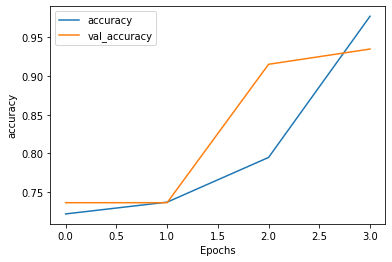

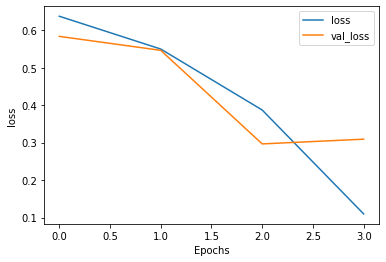

In [ ]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

## Probemos nuestro modelo

In [ ]:
validation_articles[50], validation_label_seq[50]

('al mal tiempo, a que él no podía estar en Madrid sino dos semanas, y por fin a la jaqueca que tenía Maximiliano aquel día. «Es mal de familia. Yo también las padezco. Pero lo que principalmente me trae descompuesto ahora es un pícaro mal de estómago... debilidad, dicen que es debilidad... Tengo que comer muy a menudo y muy poca cantidad... esta es la cosa... Es efecto del excesivo trabajo... ¡qué le vamos a hacer! Al llegar esta hora se me pone aquí un perrito... lo mismo que un perrito que me estuviera mordiendo. Y como no le eche algo al condenado, me da muy mal rato». --Si quiere usted... aguarde usted... yo...--dijo Fortunata pasando revista mental a su pobre despensa. --Quite usted allá, criatura... No faltaba más... ¿Piensa que no me puedo pasar...? No es que yo apetezca nada; lo tomo hasta con asco; pero me sienta bien, conozco que me sienta bien. --Si quiere usted, traeré... No tengo en casa; pero bajaré a la tienda... --Quite usted allá... no me lo diga ni en broma... Vaya, 

In [ ]:
txt = ['''
para que el triunfo fuese completo era menester que a Maxi le entrase una enfermedad asquerosa, repugnante y pestífera, de esas que ahuyentan hasta a los más allegados. Ella, entonces, daría pruebas de ser tan ángel como otra cualquiera, y tendría alma, paciencia, valor y estómago para todo. «Y entonces vería _esa_ si aquí hay perfecciones o no hay perfecciones, y que cada una es cada una... Lo malo sería que no lo viese, porque acá no ha de venir...». Maximiliano la distrajo de esta meditación, dando quejidos profundos. Ya conocía aquello su mujer y sabía el remedio, que era volverlo suavemente del otro lado... «¡Qué sueño!--murmuró Maxi medio despierto--. Soñaba que te habías marchado... y yo te había cogido de un pie, y tú tirabas, y yo tiraba más, y tirando se me rompía la bolsa del aneurisma, y todo el cuarto se llenaba de sangre, todo el cuarto, hasta el techo...». Le arrulló para que se durmiera, y ella se durmió también. Levantose temprano porque tenía que trabajar. Después de las nueve, cuando entró en la alcoba a ver si a su marido se le ofrecía alguna cosa, este se estaba vistiendo, y en una disposición de ánimo muy distinta de la que tuviera la noche anterior. No sólo parecía recobrado de su debilidad, sino que estaba inquieto, ágil y como si acabara de tomar un excitante muy enérgico. En cuanto entró su mujer, se fue derecho a ella, abotonándose el cuello de la camisa, y en tono
''']
seq = tokenizer.texts_to_sequences(txt)
padded = pad_sequences(seq, maxlen=max_length)
pred = model.predict(padded)
print(pred)
print("Parece una secuencia de una novela de Galdós" if pred[0] > 0.5 else "Parece que esta novela pertenece a Emilia Pardo Bazán")

[[0.9613426]]
Parece una secuencia de una novela de Galdós
